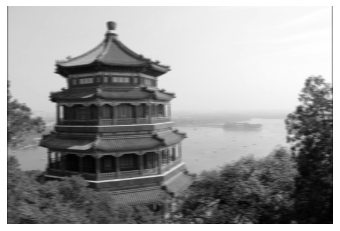

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.axis('off')
plt.show()

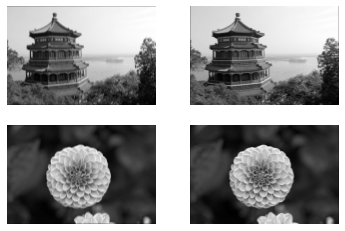

In [2]:
for image_index in (0, 1):
    for filter_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + filter_index + 1)
        plt.axis('off')
        plt.imshow(outputs[image_index, :, :, filter_index], cmap='gray')
plt.show()

In [3]:
from tensorflow import keras
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                          padding='SAME', activation='relu')

In [4]:
depth_pool = keras.layers.Lambda(
    lambda x: tf.nn.max_pool(x, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding='valid'))

In [5]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [6]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_full.shape

(60000, 28, 28)

In [7]:
x_train, x_valid = x_train_full[5000:] / 255., x_train_full[:5000] / 255.
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]
x_test = x_test / 255.

In [8]:
x_train.shape

(55000, 28, 28)

In [9]:
x_train = x_train[:, :, :, np.newaxis]
x_valid = x_valid[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]
# y_train = y_train[:, np.newaxis]
# y_valid = y_valid[:, np.newaxis]
# y_test = y_test[:, np.newaxis]

In [10]:
y_train.shape

(55000,)

In [11]:
from functools import partial

Conv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu',
                padding='SAME')
MaxPool = partial(keras.layers.MaxPooling2D, pool_size=2)

model = keras.models.Sequential([
    Conv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    MaxPool(),
    Conv2D(filters=128),
    Conv2D(filters=128),
    MaxPool(),
    Conv2D(filters=256),
    Conv2D(filters=256),
    MaxPool(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
             metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_valid, y_valid))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 285s 165ms/step - loss: 0.9997 - accuracy: 0.6284 - val_loss: 0.3534 - val_accuracy: 0.8590
Epoch 2/10
1719/1719 [==============================] - 279s 162ms/step - loss: 0.4125 - accuracy: 0.8564 - val_loss: 0.2852 - val_accuracy: 0.8978
Epoch 3/10
1719/1719 [==============================] - 279s 162ms/step - loss: 0.3409 - accuracy: 0.8828 - val_loss: 0.2700 - val_accuracy: 0.8976
Epoch 4/10
1719/1719 [==============================] - 271s 157ms/step - loss: 0.3014 - accuracy: 0.8954 - val_loss: 0.2495 - val_accuracy: 0.9074
Epoch 5/10
1719/1719 [==============================] - 270s 157ms/step - loss: 0.2729 - accuracy: 0.9047 - val_loss: 0.2432 - val_accuracy: 0.9112
Epoch 6/10
1719/1719 [==============================] - 270s 157ms/step - loss: 0.2531 - accuracy: 0.9120 - val_loss: 0.2409 - val_accuracy: 0.9152
Epoch 7/10
1719/1719 [==============================] - 272s 158ms/step - loss: 0.2264 - accuracy: 0.9217 - val_

In [13]:
score

[0.28962621092796326, 0.9093999862670898]

## ResNet-34

In [11]:
from functools import partial
Conv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            Conv2D(filters=filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            Conv2D(filters=filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Conv2D(filters=filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        return self.activation(z + skip_z)

In [12]:
model = keras.models.Sequential()
model.add(Conv2D(filters=64, kernel_size=7, strides=2, 
                 input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

In [14]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 10s 0us/step


In [15]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to C:\Users\sinjy\tensorflow_datasets\tf_flowers\3.0.0. Subsequent calls will reuse this data.


In [19]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [20]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3670>

In [21]:
class_names = info.features['label'].names

In [22]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [23]:
n_classes = info.features['label'].num_classes

In [24]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [25]:
test_set_raw, valid_set_raw, train_set_raw = \
tfds.load('tf_flowers', split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
         as_supervised=True)

In [26]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [29]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [34]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [35]:
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [40]:
batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [41]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [42]:
for layer in base_model.layers:
    layer.trainable = False

In [43]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 220s 3s/step - loss: 1.2019 - accuracy: 0.7034 - val_loss: 1.1733 - val_accuracy: 0.8294
Epoch 2/5
86/86 [==============================] - 227s 3s/step - loss: 0.4323 - accuracy: 0.8970 - val_loss: 0.8533 - val_accuracy: 0.8494
Epoch 3/5
86/86 [==============================] - 3191s 38s/step - loss: 0.3234 - accuracy: 0.9201 - val_loss: 0.6183 - val_accuracy: 0.8639
Epoch 4/5
86/86 [==============================] - 210s 2s/step - loss: 0.2328 - accuracy: 0.9325 - val_loss: 0.5772 - val_accuracy: 0.8584
Epoch 5/5
86/86 [==============================] - 218s 3s/step - loss: 0.2007 - accuracy: 0.9376 - val_loss: 0.5377 - val_accuracy: 0.8802


In [46]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 1287s 15s/step - loss: 0.4330 - accuracy: 0.8548 - val_loss: 0.5841 - val_accuracy: 0.8548
Epoch 2/5
86/86 [==============================] - 1312s 15s/step - loss: 0.1464 - accuracy: 0.9598 - val_loss: 0.3315 - val_accuracy: 0.9093
Epoch 3/5
86/86 [==============================] - 1361s 16s/step - loss: 0.0808 - accuracy: 0.9729 - val_loss: 0.2352 - val_accuracy: 0.9183
Epoch 4/5
86/86 [==============================] - 1347s 16s/step - loss: 0.0429 - accuracy: 0.9836 - val_loss: 0.2467 - val_accuracy: 0.9147
Epoch 5/5
86/86 [==============================] - 2130s 25s/step - loss: 0.0291 - accuracy: 0.9922 - val_loss: 0.2354 - val_accuracy: 0.9274


In [47]:
model.evaluate(test_set)

12/12 [==============================] - 20s 2s/step - loss: 0.3208 - accuracy: 0.9128


[0.3208339512348175, 0.912806510925293]

# 연습문제 9 번

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
x_train, x_valid = x_train[:50000] / 255., x_train[50000:] / 255.
y_train, y_valid = y_train[:50000], y_train[50000:]

In [5]:
x_test = x_test / 255.

In [6]:
x_train = x_train[:, :, :, np.newaxis]
x_valid = x_valid[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

In [7]:
x_train.shape

(50000, 28, 28, 1)

In [8]:
from functools import partial

Conv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='same')

model = keras.models.Sequential([
    Conv2D(100, input_shape=(28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    Conv2D(200, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    Conv2D(200),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

In [12]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=100, 
          validation_data=(x_valid, y_valid), 
          callbacks=[keras.callbacks.EarlyStopping(patience=10), 
                     keras.callbacks.TensorBoard(log_dir='my_logs/mnist_log')])

Epoch 1/100
1563/1563 [==============================] - 369s 236ms/step - loss: 0.4237 - accuracy: 0.9345 - val_loss: 0.0654 - val_accuracy: 0.9839
Epoch 2/100
1563/1563 [==============================] - 379s 242ms/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.0642 - val_accuracy: 0.9828
Epoch 3/100
1563/1563 [==============================] - 384s 246ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.0541 - val_accuracy: 0.9844
Epoch 4/100
1563/1563 [==============================] - 369s 236ms/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.0569 - val_accuracy: 0.9848
Epoch 5/100
1563/1563 [==============================] - 368s 235ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0503 - val_accuracy: 0.9889
Epoch 6/100
1563/1563 [==============================] - 369s 236ms/step - loss: 0.0178 - accuracy: 0.9941 - val_loss: 0.0434 - val_accuracy: 0.9884
Epoch 7/100
1563/1563 [==============================] - 370s 237ms/step - loss: 0.0130 - accuracy: 0.9955

In [13]:
model.evaluate(x_test, y_test) 

313/313 [==============================] - 14s 46ms/step - loss: 0.0620 - accuracy: 0.9901


[0.06202511116862297, 0.9901000261306763]

In [ ]:
class 